In [1]:
import h2o
from h2o.automl import H2OAutoML

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,6 mins 46 secs
H2O_cluster_timezone:,Europe/Kiev
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,4 months and 3 days
H2O_cluster_name:,H2O_from_python_38066_s16bo9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.517 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [10]:
import os
import sys
sys.path.insert(0, os.path.dirname('C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part'))

import pandas as pd

from ml_part.random_forest.data_prep.preparation import DataPreparation
from ml_part.random_forest.train import RFTrain

CSV_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\remained_features_logP_08.02_v4_fixed_distances_chirality.csv'
smiles_filepath = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\smiles_to_index.pkl'

dataPreparation = DataPreparation(CSV_PATH)

unimportant_features_to_drop = ['dipole_moment']
X, y = dataPreparation.prepare_data_for_RF(is_pKa=False,
                                           use_mandatory_features=True,
                                           is_remove_outliers=True,
                                           is_remove_nan=False,
                                           outliers_features_to_skip=unimportant_features_to_drop)

LOGP_FEATURES = ['f_freedom', 'PPSA5', 'mol_num_cycles', 'nFRing', 'nF', 'identificator', 'f_atom_fraction',
                 'mol_weight', 'dipole_moment', 'nHRing', 'nO', 'PBF', 'nC', 'nARing',
                 'cis/trans', 'PNSA5', 'FPSA3', 'mol_volume', 'RPCS', 'GeomShapeIndex',
                 'WPSA5', 'TASA', 'f_to_fg', 'avg_atoms_in_cycle', 'nFHRing',
                 'chirality']

features_to_drop = []
for feature_name in X.columns:
    if feature_name not in LOGP_FEATURES:
        features_to_drop.append(feature_name)


X = X.drop(features_to_drop, axis=1)

rf_train = RFTrain(X=X, 
                   y=y,
                   smiles_filepath=smiles_filepath,
                   is_pKa=False,
                   k_folds=2)

y_train = rf_train.y_train
X_train = rf_train.X_train

y_test = rf_train.y_test
X_test = rf_train.X_test

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(len(train_df), len(test_df))

train = h2o.H2OFrame(train_df)
test = h2o.H2OFrame(test_df)

True
183
['f_freedom', 'distance_between_atoms_in_cycle_and_f_group', 'PPSA5', 'mol_num_cycles', 'nFRing', 'nAHRing', 'angle_R1X1R2', 'nF', 'identificator', 'mol_weight', 'dipole_moment', 'nHRing', 'nO', 'PBF', 'nC', 'angle_X2X1R1', 'nARing', 'angle_R2X2R1', 'cis/trans', 'PNSA5', 'FPSA3', 'naRing', 'tpsa+f', 'mol_volume', 'RPCS', 'f_atom_fraction', 'GeomShapeIndex', 'WPSA5', 'TASA', 'f_to_fg', 'dihedral_angle', 'nFARing', 'distance_between_atoms_in_f_group_centers', 'avg_atoms_in_cycle', 'angle_X1X2R2', 'nFHRing', 'nFAHRing', 'chirality', 'pKa', 'logP']
mol_volume outliers indexes: [127]
f_atom_fraction outliers indexes: [124]
distance_between_atoms_in_f_group_centers outliers indexes: [ 35 167]
logP outliers indexes: [82, 83]
Remains rows:172, amount of features: 40
147 25
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [17]:
model_path = r'C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part\h2o_model\models\16.04.24_proper_train_crossval\logP\StackedEnsemble_BestOfFamily_5_AutoML_2_20240416_130202'

logP_model = h2o.load_model(model_path)

test_df = test_df[LOGP_FEATURES + ['logP']]
test = h2o.H2OFrame(test_df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
C:\Users\38066\AppData\Local\Temp\ipykernel_21140\144059703.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.barh(sum_rows.keys()[sorted_idx][::-1][:][::-1], sum_rows[sorted_idx][::-1][:][::-1])


Text(0.5, 0, 'H2O Feature Importance')

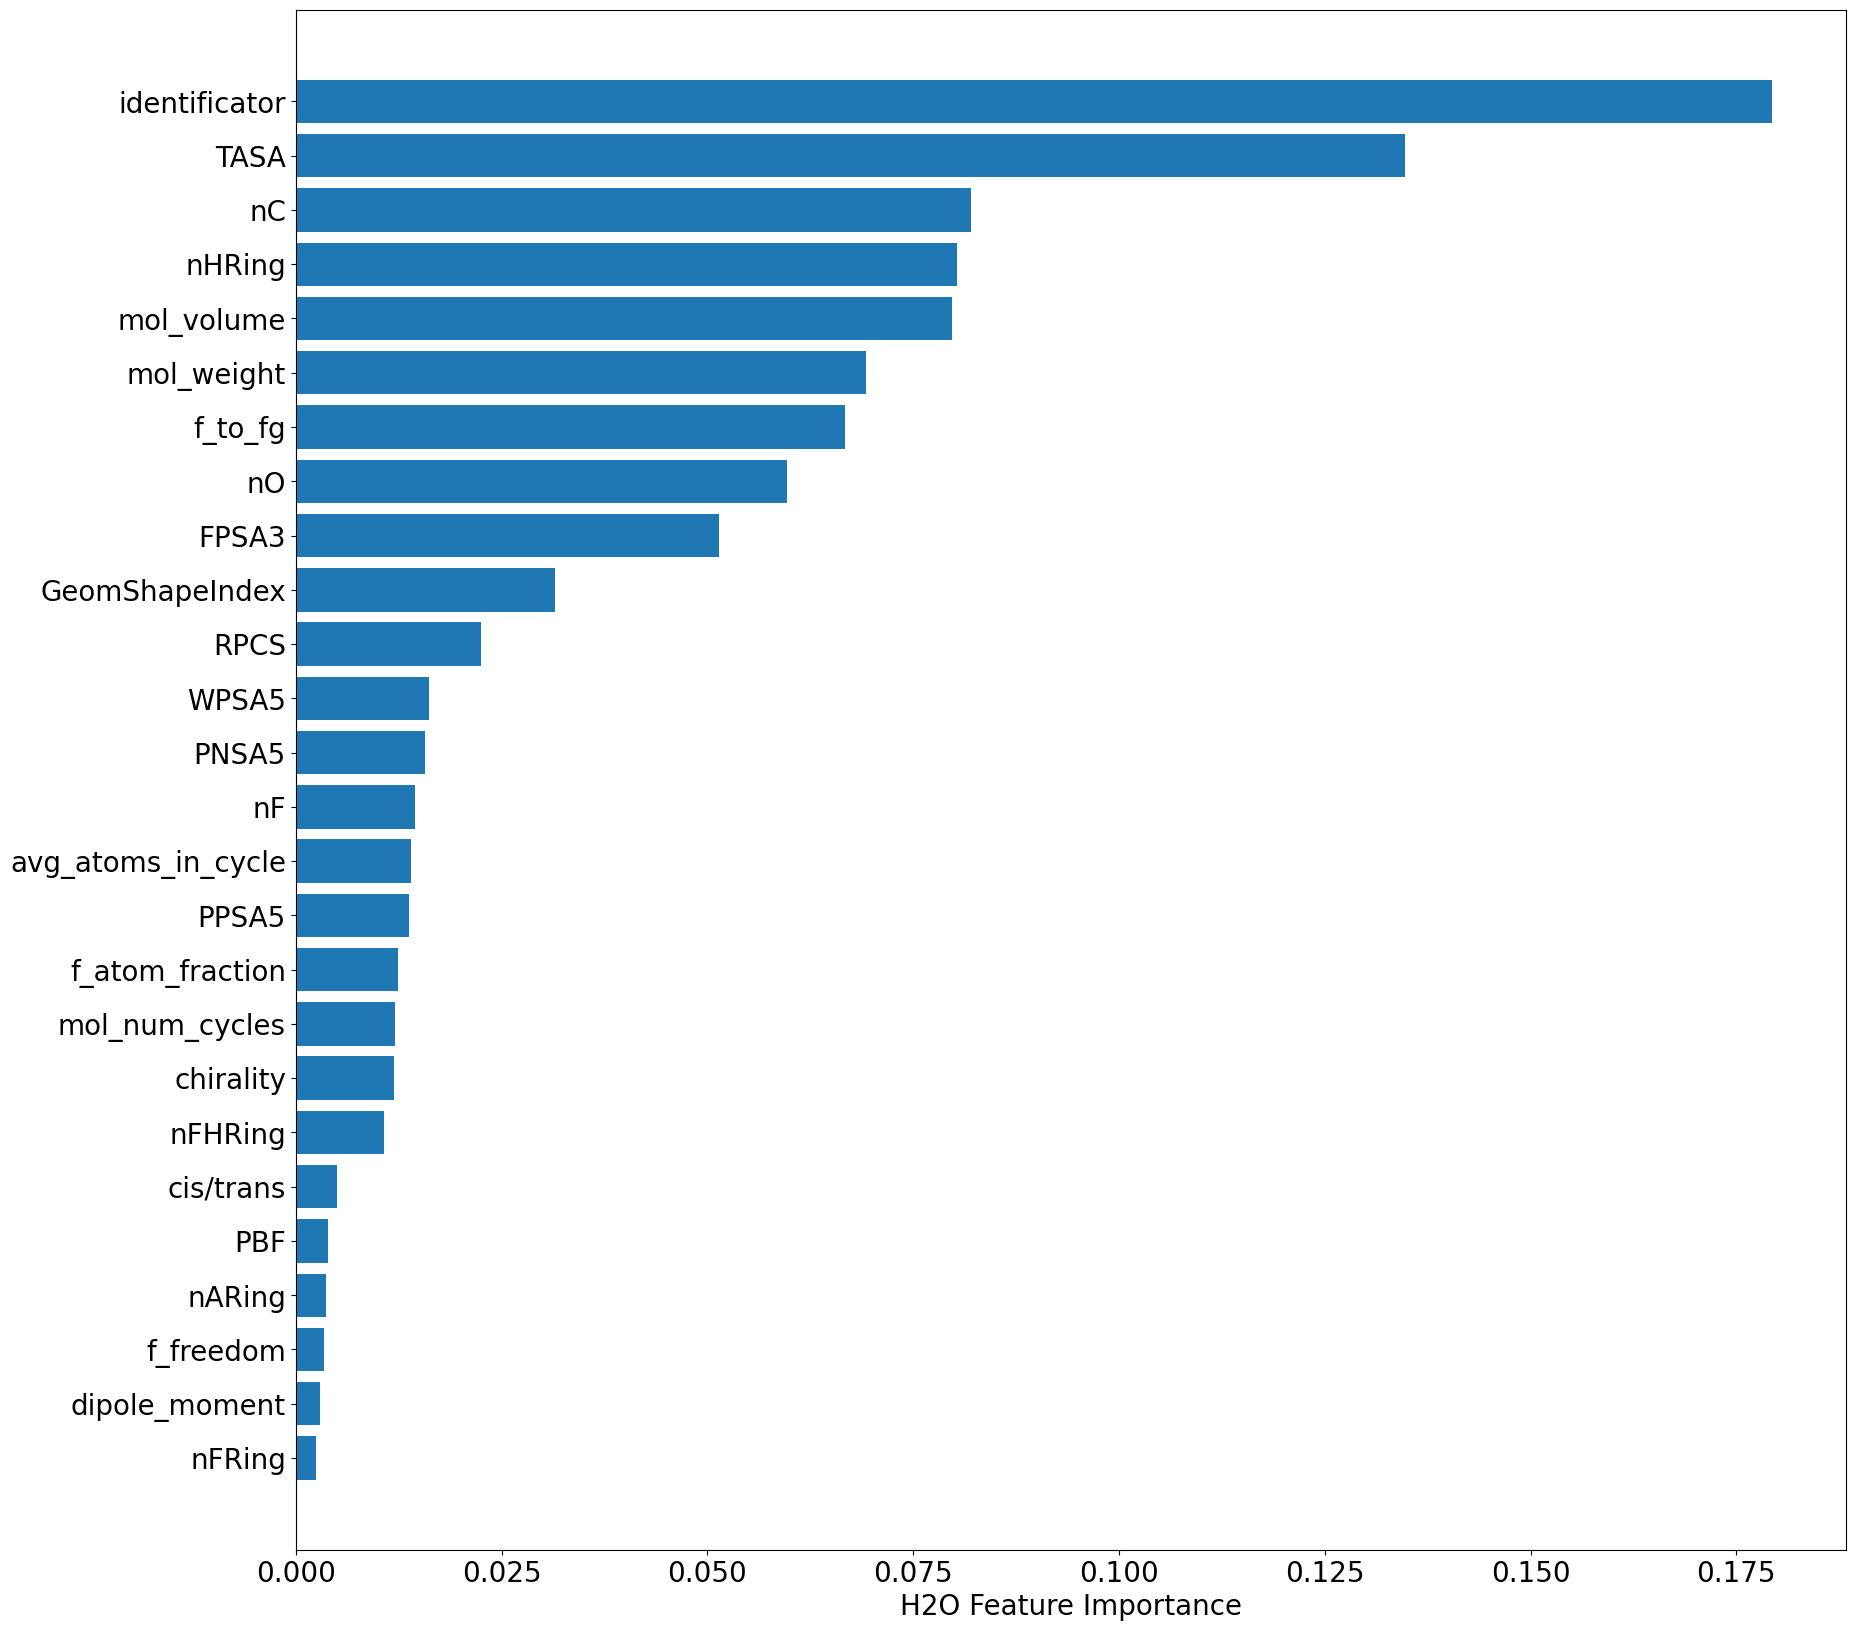

In [20]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

permutation_varimp = logP_model.permutation_importance(test, use_pandas=True, n_repeats=1000)

sum_rows = permutation_varimp.sum(axis=1)
sum_rows = sum_rows / sum(sum_rows)

sorted_idx = sum_rows.argsort()
plt.figure(figsize=(20,20))
plt.barh(sum_rows.keys()[sorted_idx][::-1][:][::-1], sum_rows[sorted_idx][::-1][:][::-1])
plt.xlabel("H2O Feature Importance")

In [23]:
sum_rows

Variable
identificator         0.179322
TASA                  0.134784
mol_volume            0.079674
nC                    0.082003
mol_weight            0.069258
nHRing                0.080384
FPSA3                 0.051464
nO                    0.059678
f_to_fg               0.066690
WPSA5                 0.016234
RPCS                  0.022463
avg_atoms_in_cycle    0.013993
mol_num_cycles        0.012104
GeomShapeIndex        0.031474
PPSA5                 0.013742
PNSA5                 0.015703
f_atom_fraction       0.012379
nF                    0.014499
chirality             0.011984
nFHRing               0.010700
nARing                0.003627
dipole_moment         0.002987
f_freedom             0.003401
cis/trans             0.004973
nFRing                0.002510
PBF                   0.003971
dtype: float64

------------

-----------

--------

logP only molecules with dihedral angle and using them as features

In [2]:
import os
import sys
sys.path.insert(0, os.path.dirname('C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part'))

import pandas as pd

from ml_part.random_forest.data_prep.preparation import DataPreparation
from ml_part.random_forest.train import RFTrain

CSV_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\remained_features_logP_08.02_v4_fixed_distances_chirality.csv'
smiles_filepath = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\smiles_to_index.pkl'

dataPreparation = DataPreparation(CSV_PATH)

outliers_features_to_skip = ['dipole_moment']
X, y = dataPreparation.prepare_data_for_RF(is_pKa=False,
                                           use_mandatory_features=True,
                                           is_remove_outliers=True,
                                           is_remove_nan=True,
                                           outliers_features_to_skip=outliers_features_to_skip)

correlated_features = ['f_atom_fraction', 'naHRing', 'nFaRing', 'nFaHRing', 'tpsa+f']
ring_features_to_remain = ['nFRing', 'nHRing', 'nARing', 'nFHRing']
features_to_drop = []
for feature_name in X.columns:
    if feature_name in correlated_features:
        features_to_drop.append(feature_name)
    elif "ring" in feature_name.lower() and feature_name not in ring_features_to_remain:
        features_to_drop.append(feature_name)
    elif len(X[feature_name].unique()) == 1:
        print(f"feature without unique values: {feature_name}")
        features_to_drop.append(feature_name)

X = X.drop(features_to_drop, axis=1)

rf_train = RFTrain(X=X, 
                   y=y,
                   smiles_filepath=smiles_filepath,
                   is_pKa=False,
                   k_folds=2)

y_train = rf_train.y_train
X_train = rf_train.X_train

y_test = rf_train.y_test
X_test = rf_train.X_test

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(len(train_df), len(test_df))

train = h2o.H2OFrame(train_df)
test = h2o.H2OFrame(test_df)

True
183
['f_freedom', 'distance_between_atoms_in_cycle_and_f_group', 'PPSA5', 'mol_num_cycles', 'nFRing', 'nAHRing', 'angle_R1X1R2', 'nF', 'identificator', 'mol_weight', 'dipole_moment', 'nHRing', 'nO', 'PBF', 'nC', 'angle_X2X1R1', 'nARing', 'angle_R2X2R1', 'cis/trans', 'PNSA5', 'FPSA3', 'naRing', 'tpsa+f', 'mol_volume', 'RPCS', 'f_atom_fraction', 'GeomShapeIndex', 'WPSA5', 'TASA', 'f_to_fg', 'dihedral_angle', 'nFARing', 'distance_between_atoms_in_f_group_centers', 'avg_atoms_in_cycle', 'angle_X1X2R2', 'nFHRing', 'nFAHRing', 'chirality', 'pKa', 'logP']
mol_volume outliers indexes: [127]
f_atom_fraction outliers indexes: [124]
distance_between_atoms_in_f_group_centers outliers indexes: [ 35 167]
logP outliers indexes: [82, 83]
Remains rows:106, amount of features: 40
90 16
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [3]:
logP_model = h2o.load_model(r'C:\\work\\DrugDiscovery\\main_git\\XAI_Chem\\ml_part\\h2o_model\\models\\08.02.24_feature_2.2\\logP\\only_molecules_with_dihedral_angle(with_angle_feature)_without_outliers\\StackedEnsemble_BestOfFamily_5_AutoML_3_20240208_224701')

c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
C:\Users\38066\AppData\Local\Temp\ipykernel_7896\144059703.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.barh(sum_rows.keys()[sorted_idx][::-1][:][::-1], sum_rows[sorted_idx][::-1][:][::-1])


Text(0.5, 0, 'H2O Feature Importance')

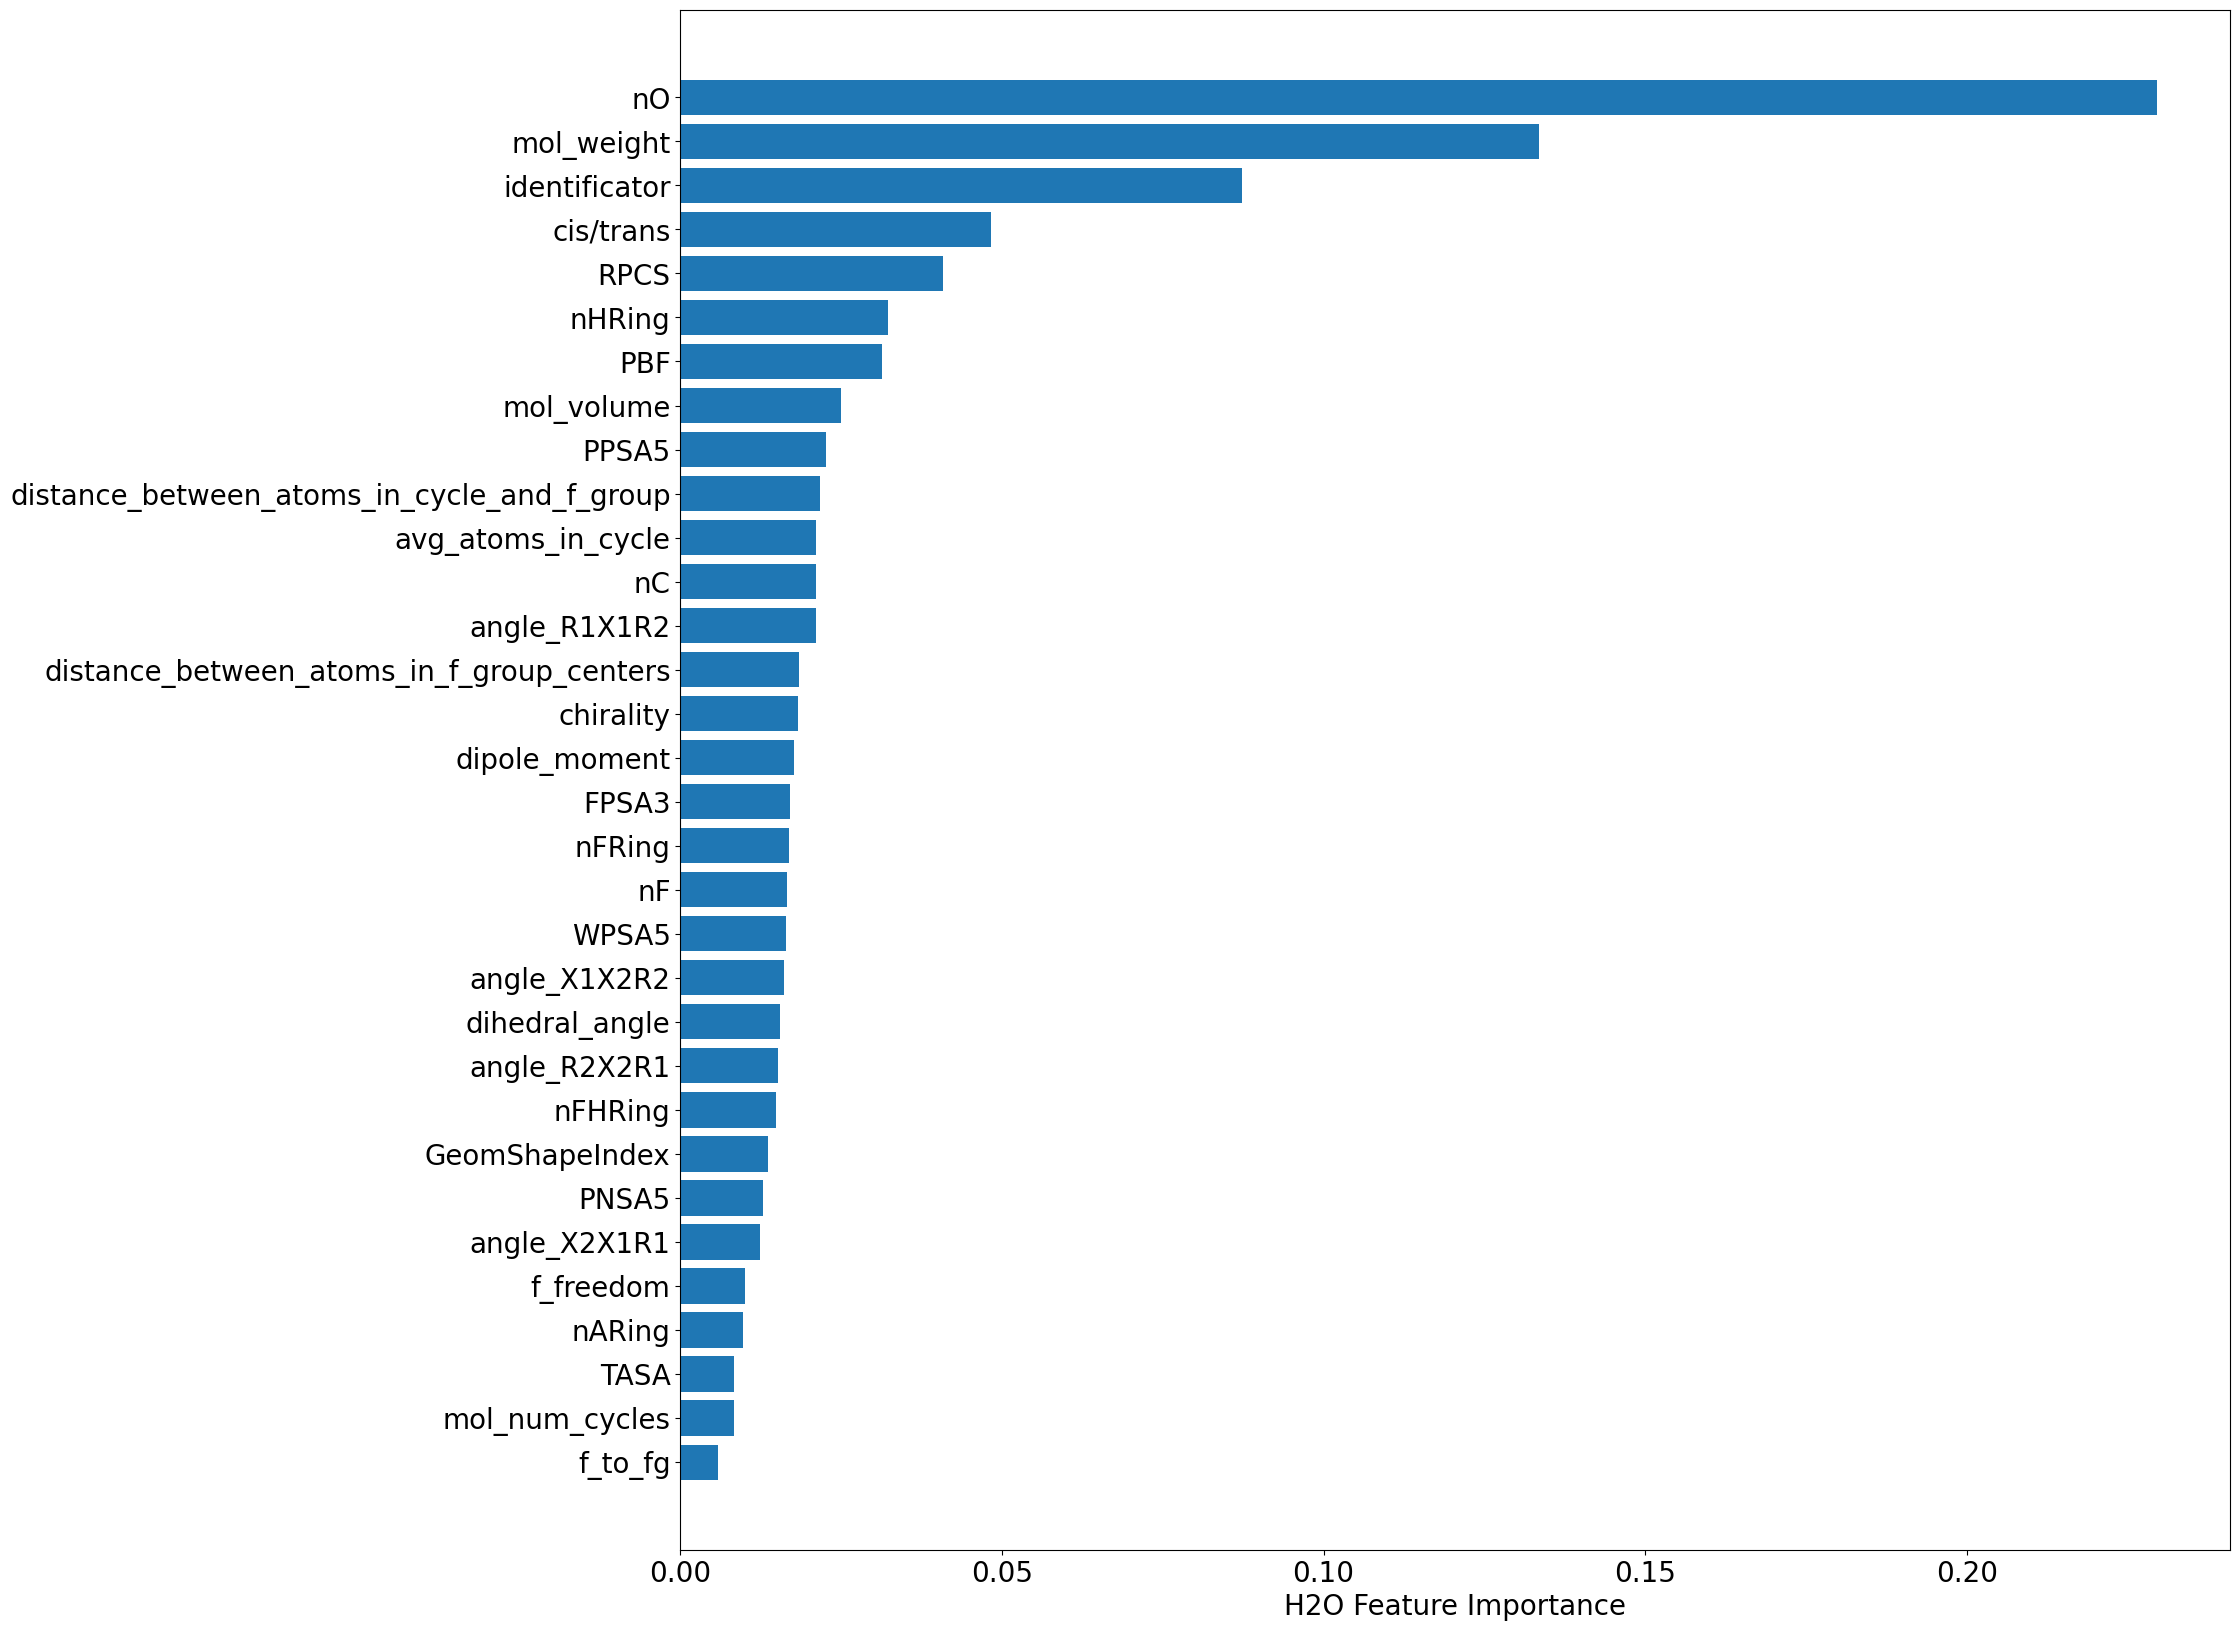

In [4]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

permutation_varimp = logP_model.permutation_importance(test, use_pandas=True, n_repeats=1000)

sum_rows = permutation_varimp.sum(axis=1)
sum_rows = sum_rows / sum(sum_rows)

sorted_idx = sum_rows.argsort()
plt.figure(figsize=(20,20))
plt.barh(sum_rows.keys()[sorted_idx][::-1][:][::-1], sum_rows[sorted_idx][::-1][:][::-1])
plt.xlabel("H2O Feature Importance")

In [5]:
sum_rows

Variable
mol_weight                                     0.133439
identificator                                  0.087343
RPCS                                           0.040803
nHRing                                         0.032354
nO                                             0.229480
nF                                             0.016533
PNSA5                                          0.012858
FPSA3                                          0.017066
distance_between_atoms_in_cycle_and_f_group    0.021777
angle_X1X2R2                                   0.016138
PBF                                            0.031380
dipole_moment                                  0.017722
dihedral_angle                                 0.015472
angle_X2X1R1                                   0.012401
avg_atoms_in_cycle                             0.021125
mol_volume                                     0.025050
GeomShapeIndex                                 0.013608
angle_R2X2R1                           